In [1]:
import pandas as pd
import geopandas as gpd
import contextily as cx

In [21]:
import os
cities = [pd.read_csv("../data/"+ i) for i in os.listdir("../data")]
cities = pd.concat(cities, ignore_index=True)
cities = cities[~cities.Location.str.contains("\\[Note")]

cities.columns = cities.columns.str.lower()

In [22]:
cities.head()

,location,latitude,longitude
0,"Funafuti, Tuvalu",-8.520470,179.199585
1,"Cape Town, South Africa",-33.924870,18.424055
2,"Metro Manila, Philippines",14.609054,121.022255
3,"Quezon City, Philippines",14.676041,121.043701
4,"Yaren, Nauru",-0.547520,166.917267


In [10]:
cities['lat'] = cities['latitude']
cities['lon'] = cities['longitude']

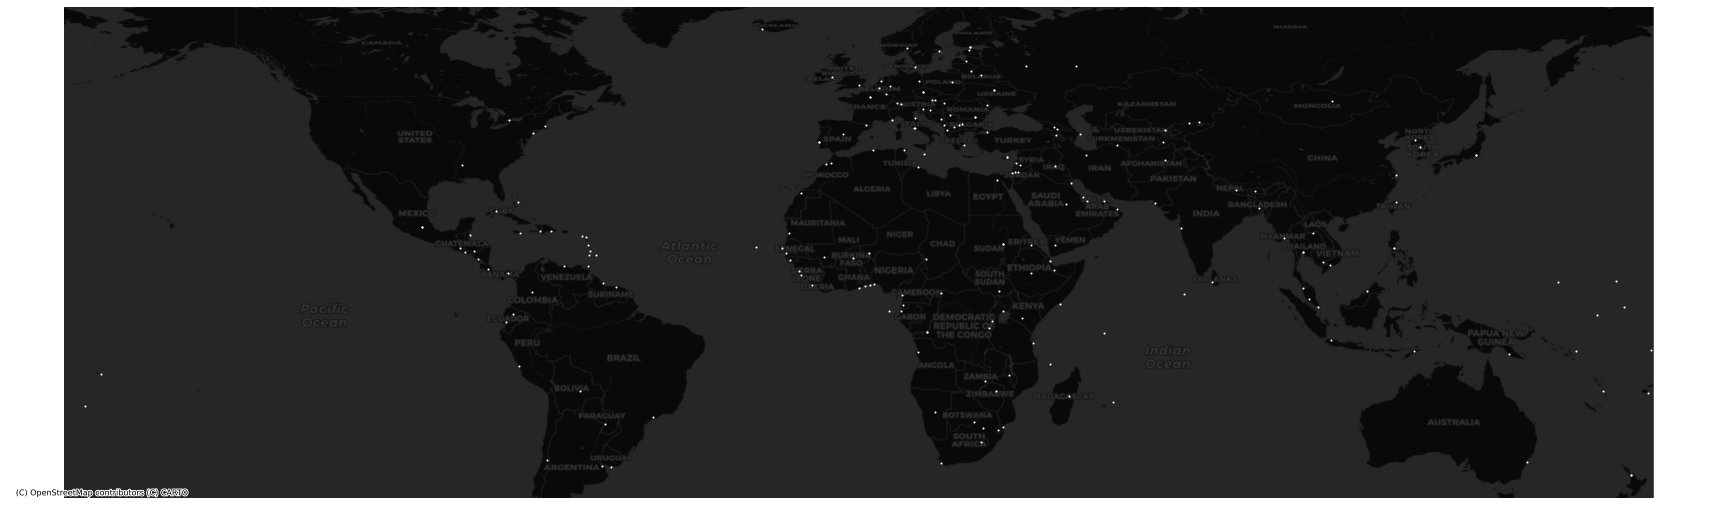

In [11]:
gdf = gpd.GeoDataFrame(cities, geometry=gpd.points_from_xy(cities.lon, cities.lat))

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(24, 12), 
                       facecolor='w',
                       constrained_layout=True, 
                       subplot_kw=dict(aspect='equal'))

cities.plot.scatter("lon", "lat", ax=ax,
                    c='w', s=1.2, alpha=0.9)

ax.set_axis_off()
cx.add_basemap(ax, crs={'init': 'epsg:4326'},
               source=cx.providers.CartoDB.DarkMatter)

fig.savefig('big-cities.png', transparent=True, dpi=120, bbox_inches='tight')    

In [12]:
populations = pd.read_html("https://en.wikipedia.org/wiki/List_of_countries_and_dependencies_by_population")
populations = populations[0]

populations = populations.iloc[1:, 0:4]

populations.columns = ['rank', 'country', 'region', 'population']

In [25]:
populations.head()

,rank,country,region,population
1,1,China,Asia,1411778724
2,2,India,Asia,1385256034
3,3,United States,Americas,332836119
4,4,Indonesia,Asia,271350000
5,5,Pakistan,Asia,225200000


In [13]:
def rejigger(name):
    if len(name) > 2:
        new_name = name[2] + " " + name[1]
        return new_name
    
    else:
        return name[1]

In [27]:
cities['country'] = [rejigger(i) for i in cities.location.str.split(", ")]
cities['city'] = [i[0] for i in cities.location.str.split(", ")]

cities['country'] = cities.country.str.replace(" of America", "")
cities['country'] = cities.country.str.replace("Democratic Republic of the ", "")
cities['country'] = cities.country.str.replace("Côte d'Ivoire", "Ivory Coast")

In [28]:
cities.head()

,location,latitude,longitude,country,city
0,"Funafuti, Tuvalu",-8.520470,179.199585,Tuvalu,Funafuti
1,"Cape Town, South Africa",-33.924870,18.424055,South Africa,Cape Town
2,"Metro Manila, Philippines",14.609054,121.022255,Philippines,Metro Manila
3,"Quezon City, Philippines",14.676041,121.043701,Philippines,Quezon City
4,"Yaren, Nauru",-0.547520,166.917267,Nauru,Yaren


In [29]:
cities.to_csv("big-cities.csv")